## Over View
Data ini adalah data sintesis transaction E-commerce 2024. data ini di buat karena E-commerce di instanbul, berlin, new york dan landon mulai memperhatikan adanya transaksi yang aneh. untuk mendeteksi dan menantisipasi transaksi tersebut di buat dataset ini.

detail dataset :
- transaction id = id transaksi
- user id = id pengguna
- account_age_days = umur akun
- total_transactions_user = total transaksi user
- avg_amount_user = rataan pembelian user
- amount = pembelian user
- country = negara user
- bin_country = penerbit kartu pembayaran
- channel = web/app
- merchant_category =  kategori produk
- promo_used = pengunaan promo
- avs_match = alamat verifikasi penagihan sesuai(1) atau tidak(0)
- cvv_result = kode verifikasi sesuai(1) atau tidak(0)
- three_ds_flag = keamanan tambahan (OTP) ya(1) atau tidak(0)
- transaction_time  = waktu transaksi
- shipping_distance_km = jarak pengiriman
- is_fraud = fraud(1) atau tidak fraud (0)


## Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from my_transformers import FrequencyEncoder, DateTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from scipy.stats import chi2_contingency

from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score,
                             confusion_matrix, classification_report,
                             ConfusionMatrixDisplay, roc_auc_score, roc_curve)

from sklearn.inspection import permutation_importance

## data check

In [2]:
df = pd.read_csv('transactions_Fraud detection.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299695 entries, 0 to 299694
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   transaction_id           299695 non-null  int64  
 1   user_id                  299695 non-null  int64  
 2   account_age_days         299695 non-null  int64  
 3   total_transactions_user  299695 non-null  int64  
 4   avg_amount_user          299695 non-null  float64
 5   amount                   299695 non-null  float64
 6   country                  299695 non-null  object 
 7   bin_country              299695 non-null  object 
 8   channel                  299695 non-null  object 
 9   merchant_category        299695 non-null  object 
 10  promo_used               299695 non-null  int64  
 11  avs_match                299695 non-null  int64  
 12  cvv_result               299695 non-null  int64  
 13  three_ds_flag            299695 non-null  int64  
 14  tran

In [4]:
df.isna().sum()

transaction_id             0
user_id                    0
account_age_days           0
total_transactions_user    0
avg_amount_user            0
amount                     0
country                    0
bin_country                0
channel                    0
merchant_category          0
promo_used                 0
avs_match                  0
cvv_result                 0
three_ds_flag              0
transaction_time           0
shipping_distance_km       0
is_fraud                   0
dtype: int64

In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
num = df.select_dtypes(include='number')
num.columns

Index(['transaction_id', 'user_id', 'account_age_days',
       'total_transactions_user', 'avg_amount_user', 'amount', 'promo_used',
       'avs_match', 'cvv_result', 'three_ds_flag', 'shipping_distance_km',
       'is_fraud'],
      dtype='object')

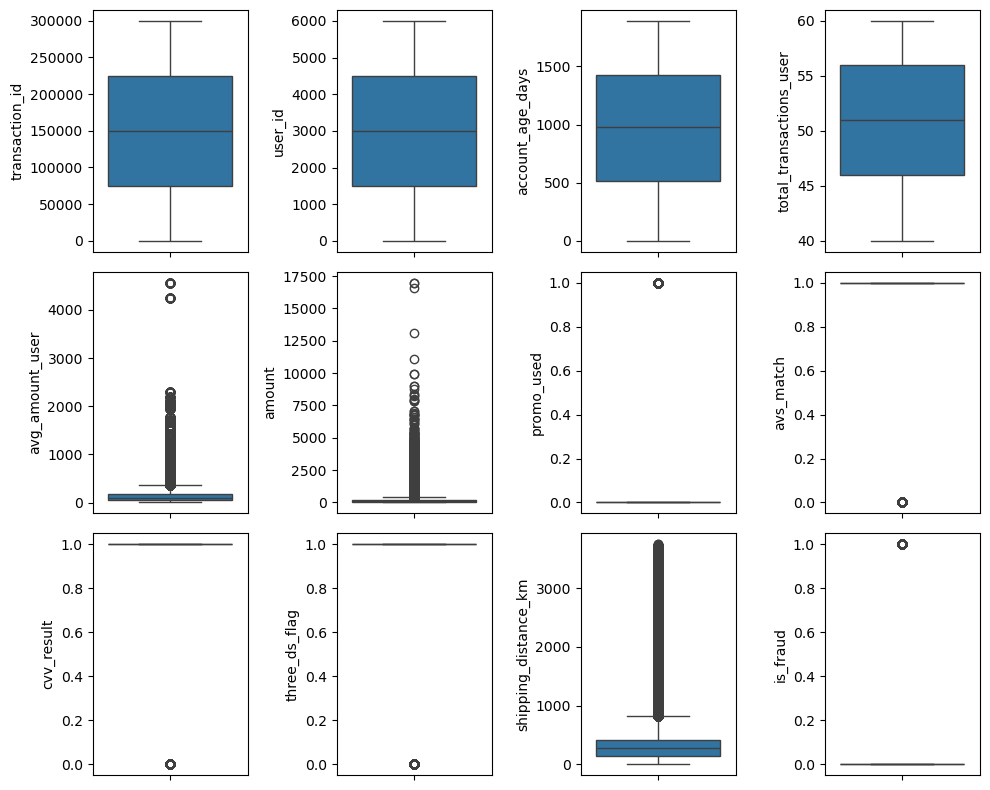

In [7]:
fig, axs = plt.subplots(3, 4,figsize=(10, 8))
for i, feature in enumerate(num.columns):
  if i >= 12:
    break
  row = i//4
  col = i % 4
  sns.boxplot(y=num[feature], ax=axs[row, col])

plt.tight_layout()
plt.show()

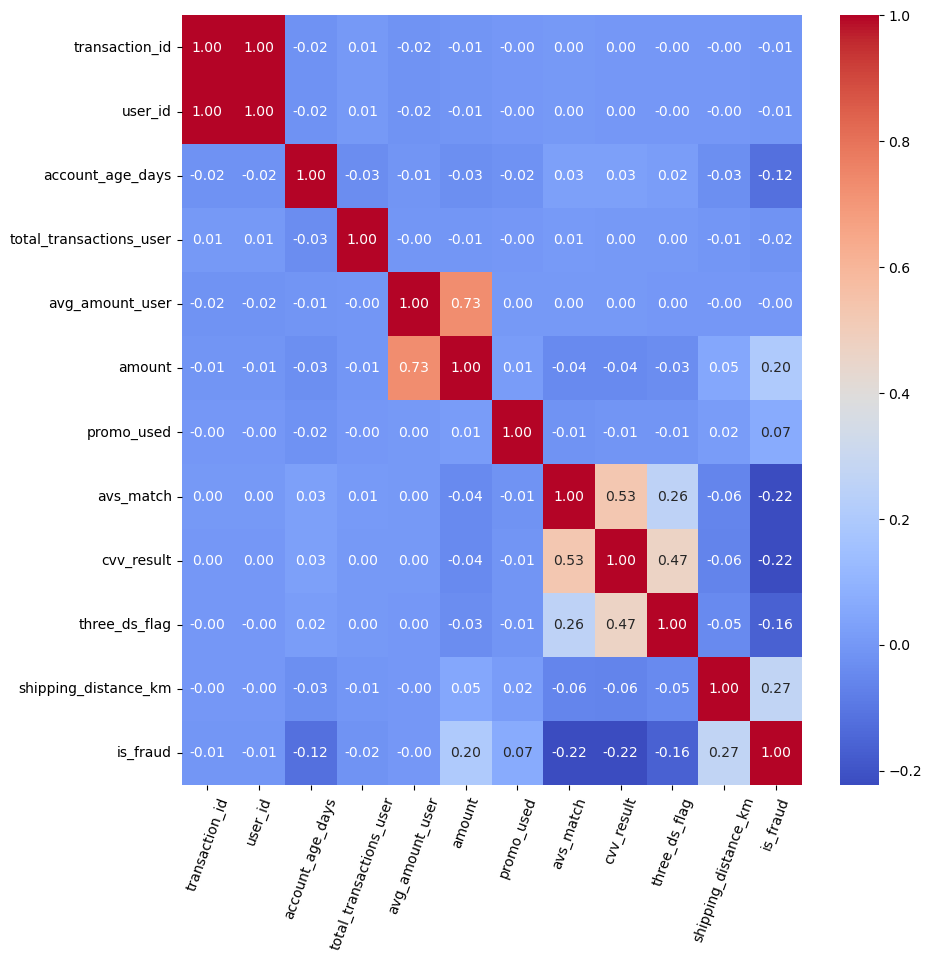

In [8]:
corr = num.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='coolwarm',fmt='.2f')
plt.xticks(rotation=70)
plt.show()

In [9]:
df = df.drop(columns=['user_id','transaction_id','avg_amount_user','avs_match'])

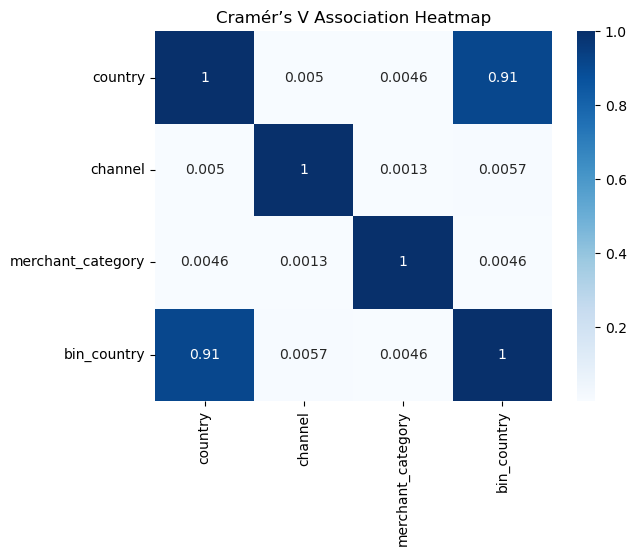

In [10]:
def cramers_v(x, y):
    contingency = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency)[0]
    n = contingency.sum().sum()
    r, k = contingency.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

cat_cols = ['country', 'channel', 'merchant_category','bin_country']

matrix = pd.DataFrame(
    index=cat_cols,
    columns=cat_cols,
    dtype=float
)

for c1 in cat_cols:
    for c2 in cat_cols:
        matrix.loc[c1, c2] = cramers_v(df[c1], df[c2])

sns.heatmap(matrix, annot=True, cmap='Blues')
plt.title("Cramér’s V Association Heatmap")
plt.show()

In [11]:
# drop bin_country
df = df.drop(columns=['bin_country'])

## Split data

In [12]:
x = df.drop('is_fraud',axis=1)
y = df['is_fraud']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=42, stratify=y)
x_train.shape, x_test.shape, y_train.shape, y_test.shape
#stratify digunakan untuk menjaga distribusi fraud tetap konsisten antara train dan test

((239756, 11), (59939, 11), (239756,), (59939,))

## Prepocessor

In [13]:
num_normal_feature = ['account_age_days','total_transactions_user']
num_skew_feature = ['shipping_distance_km','amount']
cat_feature = ['country','channel','merchant_category']
biner_feature = ['promo_used','three_ds_flag']
date_feature = ['transaction_time']

saya menggunakan OOP pada transaction_time dan juga Encode data kategori.

ini saya lakukan karena :

kategori ->
- data kategori memiliki unique value banyak
- menggunakan RandomForest
- fine tuning dengan Cross Validation
- volume data akan membengkak

datetime ->
- menghindari data leakage
- transform terjadi pada pipeline

In [13]:
#OOP convert category data (object to frequency)

In [14]:
#OOP transaction_time (object to datetime)


## Pipeline

In [14]:
# 1. DEFINISI PIPELINE KECIL
num_normal_feature_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

num_skew_feature_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(np.log1p, validate=False)),
    ('scaler', StandardScaler())
])

cat_feature_pipeline = Pipeline([
    ('freq', FrequencyEncoder(cols=cat_feature))
])

In [15]:
#preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num_nor', num_normal_feature_pipeline, num_normal_feature),
        ('num_skew', num_skew_feature_pipeline, num_skew_feature),
        ('cat', cat_feature_pipeline, cat_feature),
        ('bin', 'passthrough', biner_feature),
    ]
)

## Model

In [17]:
#sebelum ini sudah melakukan uji model dengan 4 model
# model = logisticregression, decisiontree, randomforest, dan XGBoost
# model terbaik adalah XGBoost

### XGBoost

In [16]:
# handle imbalance pada xgboost menggunakan scale_pos_weight
#scale_pos_weight = jumlah non fraud/jumlah fraud
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
value_scale_pos_weight = neg/pos
value_scale_pos_weight

np.float64(44.32249527410208)

In [17]:
pipeline_xgb = Pipeline([
    ('date', DateTransformer('transaction_time')),
    ('prepocessor', preprocessor),
    ('algo_xgb', XGBClassifier(
        eval_metric='logloss',
        random_state=42
    ))
])

In [18]:
pipeline_xgb.fit(x_train, y_train)

Pipeline(steps=[('date', DateTransformer(col='transaction_time')),
                ('prepocessor',
                 ColumnTransformer(transformers=[('num_nor',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['account_age_days',
                                                   'total_transactions_user']),
                                                 ('num_skew',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   St...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

scoring baseline

In [19]:
y_pred_xgb = pipeline_xgb.predict(x_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     58617
           1       0.87      0.63      0.73      1322

    accuracy                           0.99     59939
   macro avg       0.93      0.82      0.86     59939
weighted avg       0.99      0.99      0.99     59939



In [20]:
print('TRAIN')
print(classification_report(y_train, pipeline_xgb.predict(x_train)))

print('TEST')
print(classification_report(y_test, pipeline_xgb.predict(x_test)))

TRAIN
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    234466
           1       0.95      0.70      0.80      5290

    accuracy                           0.99    239756
   macro avg       0.97      0.85      0.90    239756
weighted avg       0.99      0.99      0.99    239756

TEST
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     58617
           1       0.87      0.63      0.73      1322

    accuracy                           0.99     59939
   macro avg       0.93      0.82      0.86     59939
weighted avg       0.99      0.99      0.99     59939



## Optimalize

### XGBoost

In [21]:
param_xgb = {
    'algo_xgb__n_estimators' : [100, 200],
    'algo_xgb__scale_pos_weight': [
        value_scale_pos_weight * 0.5,
        value_scale_pos_weight,
        value_scale_pos_weight * 2],
    'algo_xgb__max_depth' : [3, 8],
    'algo_xgb__learning_rate' : [0.01, 0.1],
    'algo_xgb__subsample' : [0.6, 0.9],
    'algo_xgb__gamma' : [0, 1]
    }

In [22]:
model_xgb= RandomizedSearchCV(pipeline_xgb, param_xgb, cv=3, n_jobs=-1, verbose=2, scoring='recall',random_state=42)
model_xgb.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('date',
                                              DateTransformer(col='transaction_time')),
                                             ('prepocessor',
                                              ColumnTransformer(transformers=[('num_nor',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['account_age_days',
                                                                                'total_transactions_user']),
                                                                              ('num_skew',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('log',
                                                                                                FunctionTransformer(...
                   n_jobs=-1,
                   param_distributions={'algo_xgb__gamma': [0, 1],
                                        'algo_xgb__learning_rate': [0.01, 0.1],
                                        'algo_xgb__max_depth': [3, 8],
                                        'algo_xgb__n_estimators': [100, 200],
                                        'algo_xgb__scale_pos_weight': [np.float64(22.16124763705104),
                                                                       np.float64(44.32249527410208),
                                                                       np.float64(88.64499054820416)],
                                        'algo_xgb__subsample': [0.6, 0.9]},
                   random_state=42, scoring='recall', verbose=2)

### scoring

In [23]:
cv_result_xgb = pd.DataFrame(model_xgb.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result_xgb[retain_cols].sort_values(by='rank_test_score').head()

,params,mean_test_score,rank_test_score
9,"{'algo_xgb__subsample': 0.6, 'algo_xgb__scale_...",0.950283,1
1,"{'algo_xgb__subsample': 0.9, 'algo_xgb__scale_...",0.930055,2
0,"{'algo_xgb__subsample': 0.6, 'algo_xgb__scale_...",0.870131,3
4,"{'algo_xgb__subsample': 0.9, 'algo_xgb__scale_...",0.869942,4
6,"{'algo_xgb__subsample': 0.9, 'algo_xgb__scale_...",0.850659,5


In [24]:
model_xgb.best_params_

{'algo_xgb__subsample': 0.6,
 'algo_xgb__scale_pos_weight': np.float64(88.64499054820416),
 'algo_xgb__n_estimators': 200,
 'algo_xgb__max_depth': 3,
 'algo_xgb__learning_rate': 0.01,
 'algo_xgb__gamma': 0}

In [25]:
print("TRAIN")
print(classification_report(y_train, model_xgb.predict(x_train)))

print("TEST")
print(classification_report(y_test, model_xgb.predict(x_test)))

TRAIN
              precision    recall  f1-score   support

           0       1.00      0.81      0.89    234466
           1       0.10      0.95      0.18      5290

    accuracy                           0.81    239756
   macro avg       0.55      0.88      0.54    239756
weighted avg       0.98      0.81      0.88    239756

TEST
              precision    recall  f1-score   support

           0       1.00      0.81      0.89     58617
           1       0.10      0.95      0.18      1322

    accuracy                           0.81     59939
   macro avg       0.55      0.88      0.54     59939
weighted avg       0.98      0.81      0.88     59939



In [26]:
y_pred_xgb = model_xgb.predict(x_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89     58617
           1       0.10      0.95      0.18      1322

    accuracy                           0.81     59939
   macro avg       0.55      0.88      0.54     59939
weighted avg       0.98      0.81      0.88     59939



In [27]:
y_pred_xgb_proba = model_xgb.predict_proba(x_test)[:,1]

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgb_proba)
roc_auc = roc_auc_score(y_test, y_pred_xgb_proba)

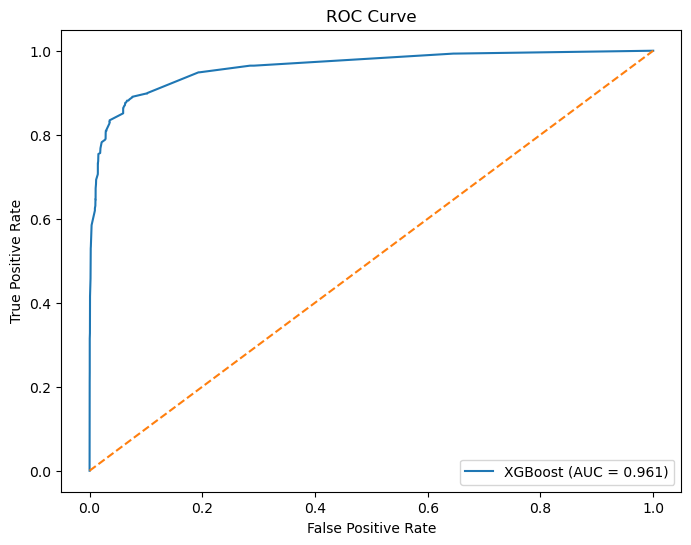

In [29]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

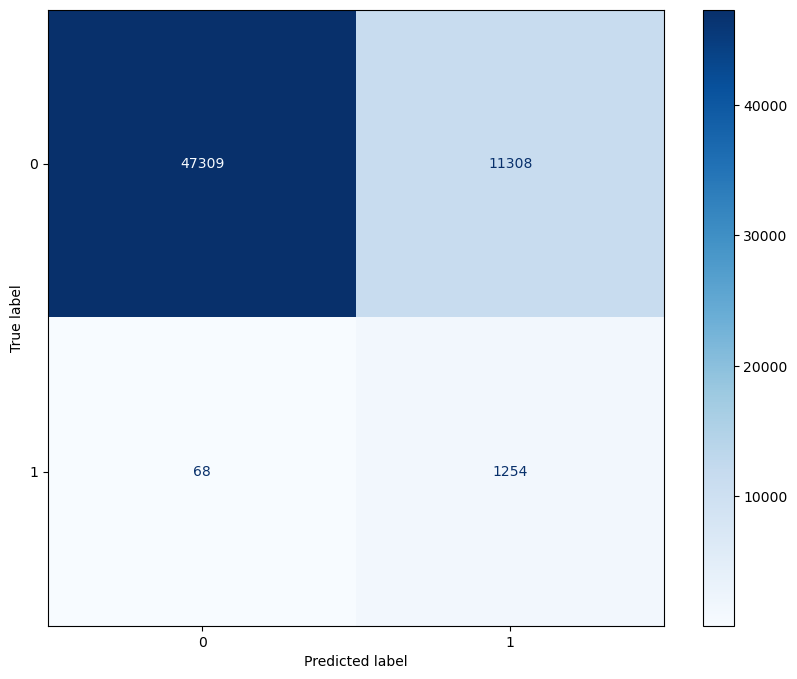

In [30]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred_xgb, labels=model_xgb.best_estimator_.classes_)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm,
                                     display_labels=model_xgb.best_estimator_.classes_)
disp_xgb.plot(ax=ax, cmap='Blues')
plt.show()

## Model Agnostic Methods

In [31]:
final_xgb = model_xgb.best_estimator_

### Feature importance

In [32]:
r = permutation_importance(
    final_xgb,
    x_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='recall',
    n_jobs=-1
)

In [33]:
top_feature = pd.DataFrame({
    'feature': x_test.columns,
    'importance': r.importances_mean
}).sort_values('importance', ascending=False)


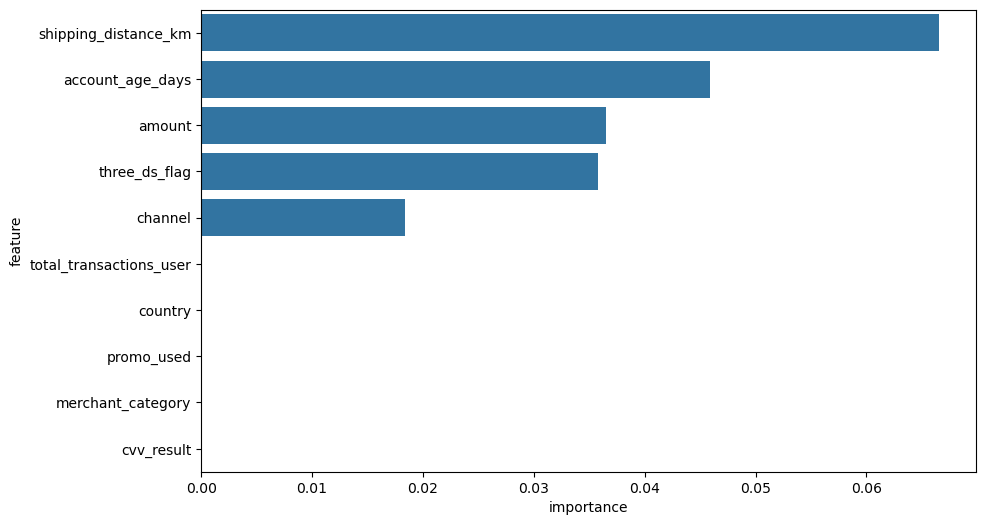

In [34]:
plt.figure(figsize=(10,6))
sns.barplot(data=top_feature.head(10), y='feature', x='importance')
plt.xticks(rotation=0)
plt.show()

In [50]:
top_feature.to_csv("feature_importance_permutation.csv", index=False)

## Treshold model base on cost

expected cost loss = count FN x cost FN + count FP x cost FP

pada case di atas dengan treshold 0.5(default) maka

expected cost loss = (118 x 600) + (3408 x 40) = 207.120

In [35]:
# melihat treshold lain berdasarkan cost handling optimal
def find_optimal_threshold(y_true, y_proba, cost_fn, cost_fp, step=0.01):
    results = []

    thresholds = np.arange(0.0, 1.01, step)

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        total_cost = (fn * cost_fn) + (fp * cost_fp)

        results.append({
            "threshold_model": t,
            "FN": fn,
            "FP": fp,
            "TP": tp,
            "TN": tn,
            "total_cost": total_cost
        })

    df = pd.DataFrame(results)
    best_row = df.loc[df["total_cost"].idxmin()]

    return best_row, df

In [36]:
best, table = find_optimal_threshold(
    y_true=y_test,
    y_proba=model_xgb.predict_proba(x_test)[:,1],
    cost_fn=650,
    cost_fp=30
)

best

threshold_model         0.74
FN                    224.00
FP                   2071.00
TP                   1098.00
TN                  56546.00
total_cost         207730.00
Name: 74, dtype: float64

In [37]:
treshold_optimal = best['threshold_model']

y_pred_xgb_optimal = (model_xgb.predict_proba(x_test)[:,1] >= treshold_optimal).astype(int)
print(classification_report(y_test, y_pred_xgb_optimal))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     58617
           1       0.35      0.83      0.49      1322

    accuracy                           0.96     59939
   macro avg       0.67      0.90      0.73     59939
weighted avg       0.98      0.96      0.97     59939



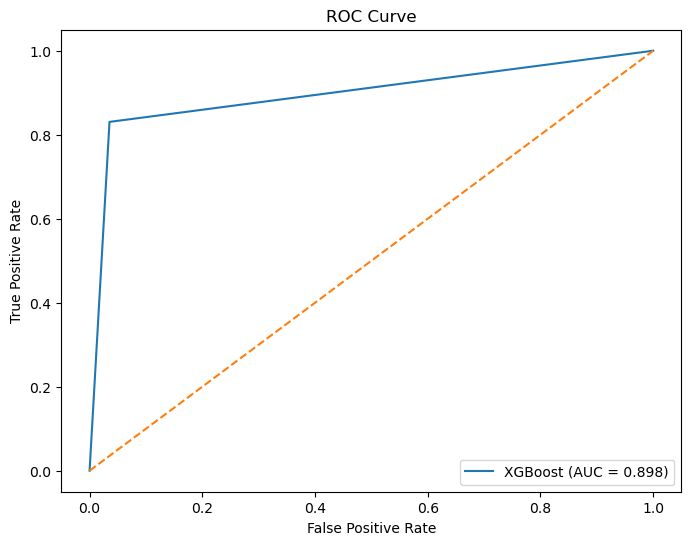

In [38]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgb_optimal)
roc_auc_optimal = roc_auc_score(y_test, y_pred_xgb_optimal)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_optimal:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

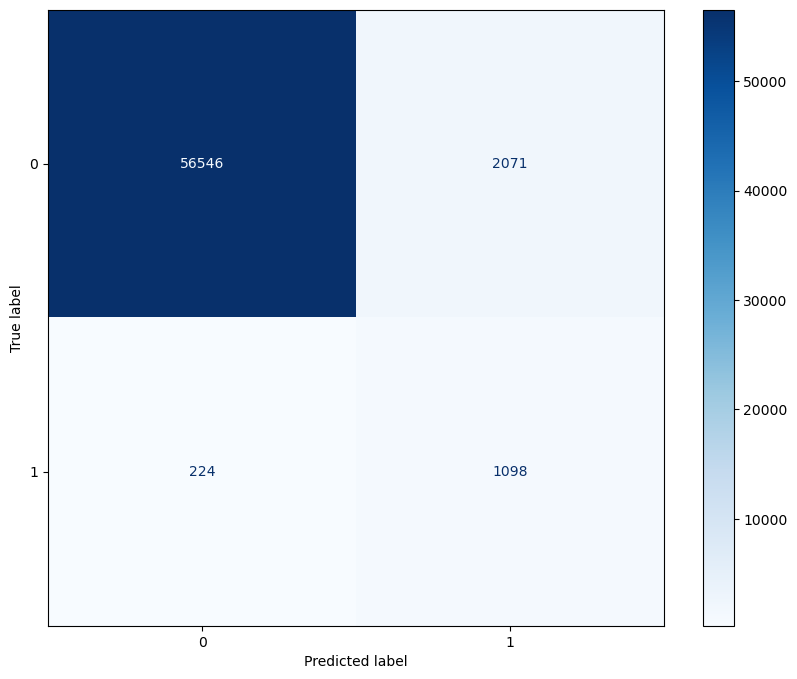

In [39]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred_xgb_optimal, labels=model_xgb.best_estimator_.classes_)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm,
                                     display_labels=model_xgb.best_estimator_.classes_)
disp_xgb.plot(ax=ax, cmap='Blues')
plt.show()

## Deploy

In [40]:
import joblib

In [41]:
final_xgb.fit(x_train,y_train)

Pipeline(steps=[('date', DateTransformer(col='transaction_time')),
                ('prepocessor',
                 ColumnTransformer(transformers=[('num_nor',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['account_age_days',
                                                   'total_transactions_user']),
                                                 ('num_skew',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   St...
                               feature_types=None, feature_weights=None,
                               gamma=0, grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [42]:
joblib.dump(final_xgb, "fraud_model.pkl")

['fraud_model.pkl']

In [43]:
table.to_csv("threshold_table.csv", index=False)

In [44]:
def select_threshold_by_cost(threshold_table, cost_fn, cost_fp):
    df = threshold_table.copy()
    df["total_cost"] = df["FN"] * cost_fn + df["FP"] * cost_fp
    best_row = df.loc[df["total_cost"].idxmin()]
    return best_row["threshold_model"]

In [45]:
import os
os.getcwd()


'd:\\projects\\fraud.app\\Fraud.app'

## test

In [46]:
import joblib

model_loaded = joblib.load("fraud_model.pkl")


In [47]:
import pandas as pd

user_df = pd.DataFrame([{
    "account_age_days": 120,
    "total_transactions_user": 15,
    "amount": 350.0,
    "country": "USA",
    "bin_country": "USA",
    "channel": "Web",
    "merchant_category": "Electronics",
    "promo_used": 0,
    "avs_match": 1,
    "cvv_result": 1,
    "three_ds_flag": 1,
    "transaction_time": "2026-01-07 17:30:00",
    "shipping_distance_km": 12.5
}])


In [48]:
proba = model_loaded.predict_proba(user_df)
proba

array([[0.78186816, 0.21813186]], dtype=float32)

In [49]:
model_loaded.named_steps["prepocessor"].feature_names_in_

array(['account_age_days', 'total_transactions_user', 'amount', 'country',
       'channel', 'merchant_category', 'promo_used', 'cvv_result',
       'three_ds_flag', 'shipping_distance_km', 'month', 'day', 'hour'],
      dtype=object)

In [52]:
model_loaded.named_steps


{'date': DateTransformer(col='transaction_time'),
 'prepocessor': ColumnTransformer(transformers=[('num_nor',
                                  Pipeline(steps=[('scaler', StandardScaler())]),
                                  ['account_age_days', 'total_transactions_user',
                                   'month', 'day', 'hour']),
                                 ('num_skew',
                                  Pipeline(steps=[('impute',
                                                   SimpleImputer(strategy='median')),
                                                  ('log',
                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                  ('scaler', StandardScaler())]),
                                  ['shipping_distance_km', 'amount']),
                                 ('cat',
                                  Pipeline(steps=[('freq',
                                                   FrequencyEncode